In this notebook, we shall use a single-cell RNAseq data to deconvolve a bulk RNAseq data.

## Datasets needed for tutorial

The datasets used in this tutorial are available as part the [DISSECT](https://github.com/robinredX/DISSECT/tutorials/data) repository. 

Sources:

The bulk RNAseq data is taken from [GSE120502](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE120502).

The single-cell RNAseq data comes from 10x Genomics and for this tutorial, we will use a sampled dataset containing 1000 cells. The complete count matrix can be downloaded at [this link] (http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz). 

### A note on the supported formats

**(1) bulkRNAseq**

A tab seperated file (gene symbols in rows, sample names in columns) as can be seen below:

In [1]:
import pandas as pd

bulk_path = "data/bulkRNAseq/bulk_gse120502.txt"

df = pd.read_table(bulk_path, index_col=0)
df.head()

,T63_LPS_FC1_4,T81_LPS_FC1_4,T104_LPS_FC1_4,T4_GARD_BATCH_2,K47_LPS_FC1_4,T4_CTL_FC5,T12_CTL_B_BATCH_2,T84_LPS_FC1_4,K44_LPS_FC1_4,K10_LPS_FC1_4,...,T70_LPS_FC1_4,K10_GARD_BATCH_2,K37_CTL_FC1_4,T5_CTL_FC5,K53_LPS_FC1_4,T120_LPS_FC5,K7_GARD_BATCH_2,K12_GARD_BATCH_2,T35_GARD_BATCH_2,K50_CTL_FC1_4
ATF7-NPFF,29.0,28.0,38.0,71.0,40.0,34.0,39.0,25.0,58.0,38.0,...,30.0,52.0,31.0,27.0,34.0,22.0,56.0,50.0,50.0,24.0
B4GAT1-DT,15.0,16.0,28.0,44.0,7.0,24.0,44.0,28.0,23.0,18.0,...,32.0,24.0,18.0,36.0,13.0,4.0,43.0,37.0,47.0,16.0
BTBD8,0.0,3.0,4.0,36.0,13.0,6.0,30.0,23.0,37.0,13.0,...,5.0,12.0,16.0,25.0,0.0,0.0,23.0,22.0,46.0,32.0
C12orf42-AS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4orf54,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


The other supported format is h5ad compatible with Scanpy >=1.8.0.

**(2) scRNAseq**

A h5ad compatible with Scanpy >=1.8.0.
Metadata included in .obs attribute as can be seen below:

In [2]:
import scanpy as sc
sc_path = "data/scRNAseq/sampled_100_data8k.h5ad"
adata = sc.read(sc_path)
adata

AnnData object with n_obs × n_vars = 1000 × 18159
    obs: 'cell_type'

## Import DISSECT module

In [3]:
import dissect

DISSECT can be configured with a config file available from the following command.

In [4]:
config = dissect.config

In [5]:
config

{'experiment_folder': '/home/user/expriment',
 'simulation_params': {'scdata': '/home/user/experiment/data.h5ad',
  'n_samples': None,
  'type': 'bulk',
  'celltype_col': 'celltype',
  'batch_col': None,
  'cells_per_sample': None,
  'downsample': None,
  'preprocess': None,
  'filter': {'min_genes': 200, 'min_cells': 3, 'mt_cutoff': 5, 'min_expr': 0},
  'concentration': None,
  'prop_sparse': 0.5,
  'generate_component_figures': True},
 'deconv_params': {'test_dataset': '../bulk.txt',
  'test_dataset_format': 'txt',
  'test_dataset_type': 'bulk',
  'duplicated': 'first',
  'normalize_simulated': 'cpm',
  'normalize_test': 'cpm',
  'var_cutoff': 0.1,
  'test_in_mix': None,
  'simulated': True,
  'sig_matrix': False,
  'mix': 'srm',
  'save_config': True,
  'network_params': {'n_hidden_layers': 4,
   'hidden_units': [512, 256, 128, 64],
   'hidden_activation': 'relu6',
   'output_activation': 'softmax',
   'loss': 'kldivergence',
   'n_steps': 5000,
   'lr': 1e-05,
   'batch_size': 64,


## Set experiment folder

In this config, **experiment_folder** specifies a non-existing experiment directory where the results would be stored

In [6]:
config["experiment_folder"] # this prints the current folder

'/home/user/expriment'

In [7]:
# we will set it to "tutorial_bulkRNAseq"

config["experiment_folder"] = "tutorial_bulkRNAseq"

## Do simulation

**simulation_params** contain hyperparameters for simulations

We can specify the path to our single-cell data, the data type, our cell type column name, and the number of samples to simulate

In [8]:
config["simulation_params"]["scdata"] = "data/scRNAseq/sampled_100_data8k.h5ad"
config["simulation_params"]["type"] = "bulk"
config["simulation_params"]["celltype_col"] = "cell_type"
config["simulation_params"]["n_samples"] = 1000

In [9]:
# by default the single-cell data passes through following QC:
config["simulation_params"]["filter"]

{'min_genes': 200, 'min_cells': 3, 'mt_cutoff': 5, 'min_expr': 0}

We will leave all other For other options in the config and their meanings, please look [here](https://github.com/imsb-uke/DISSECT/blob/main/dissect/configs/config.py).

**simulate** function from dissect can be used for simulation. It takes as input the above config.

Outputs

**(1) Simulated data**

Saves the simulated data as h5ad object in the folder simulations/simulated.h5ad within the config["experiment_folder"].

**(2) Plots**

The function also prints and saves the following if config["generate_component_figures"] is set to True (default):

(1) boxplots showing the counts and proportions of cell types in the simulated data,

(2) a scatter plot showing principal components of the simulated data colored by cell type proportions, and

(3) a scatter plot showing principal components of the cell type-specific gene expression profiles for each sample.

None
Index(['cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'n_counts'],
      dtype='object')
Number of batches in single-cell data is 1.


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 154.10it/s]


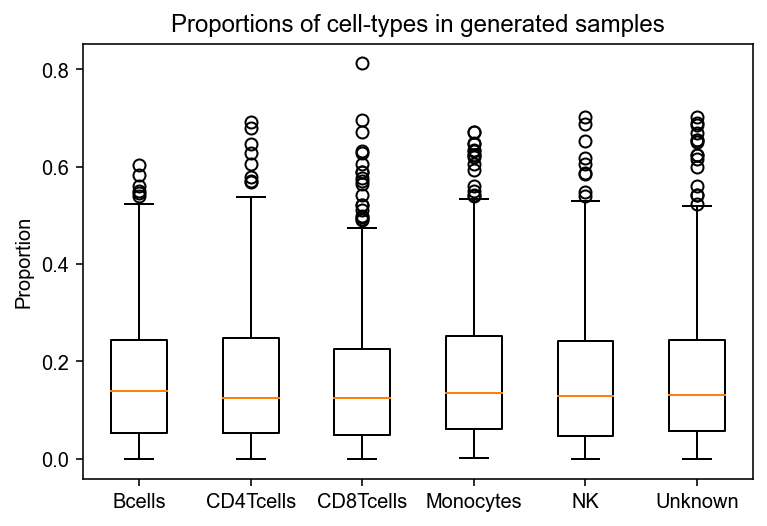

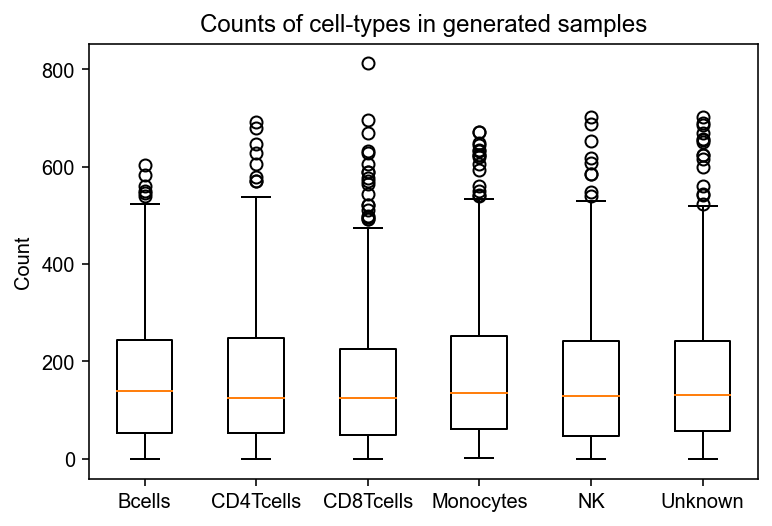

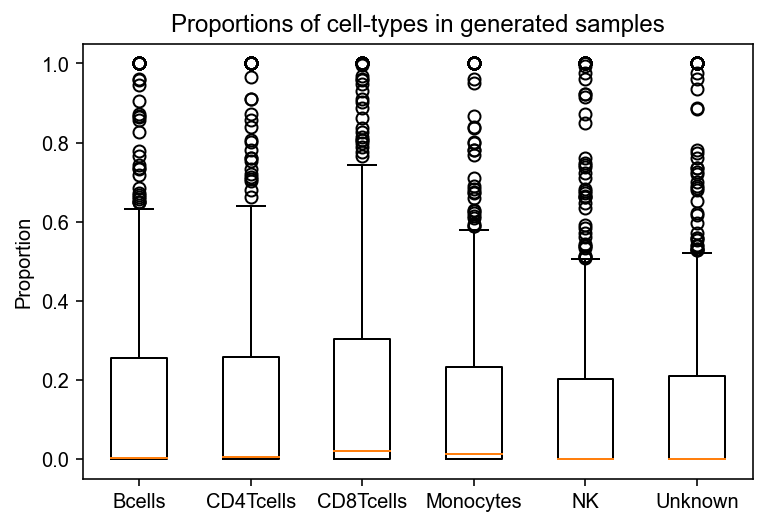

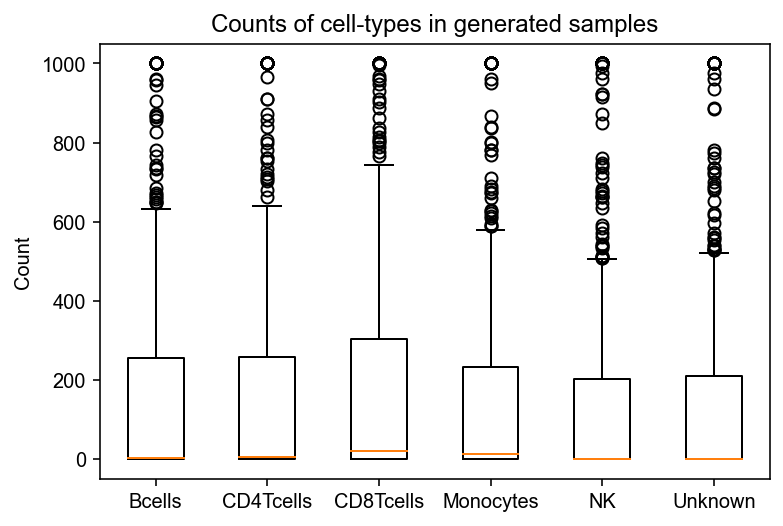

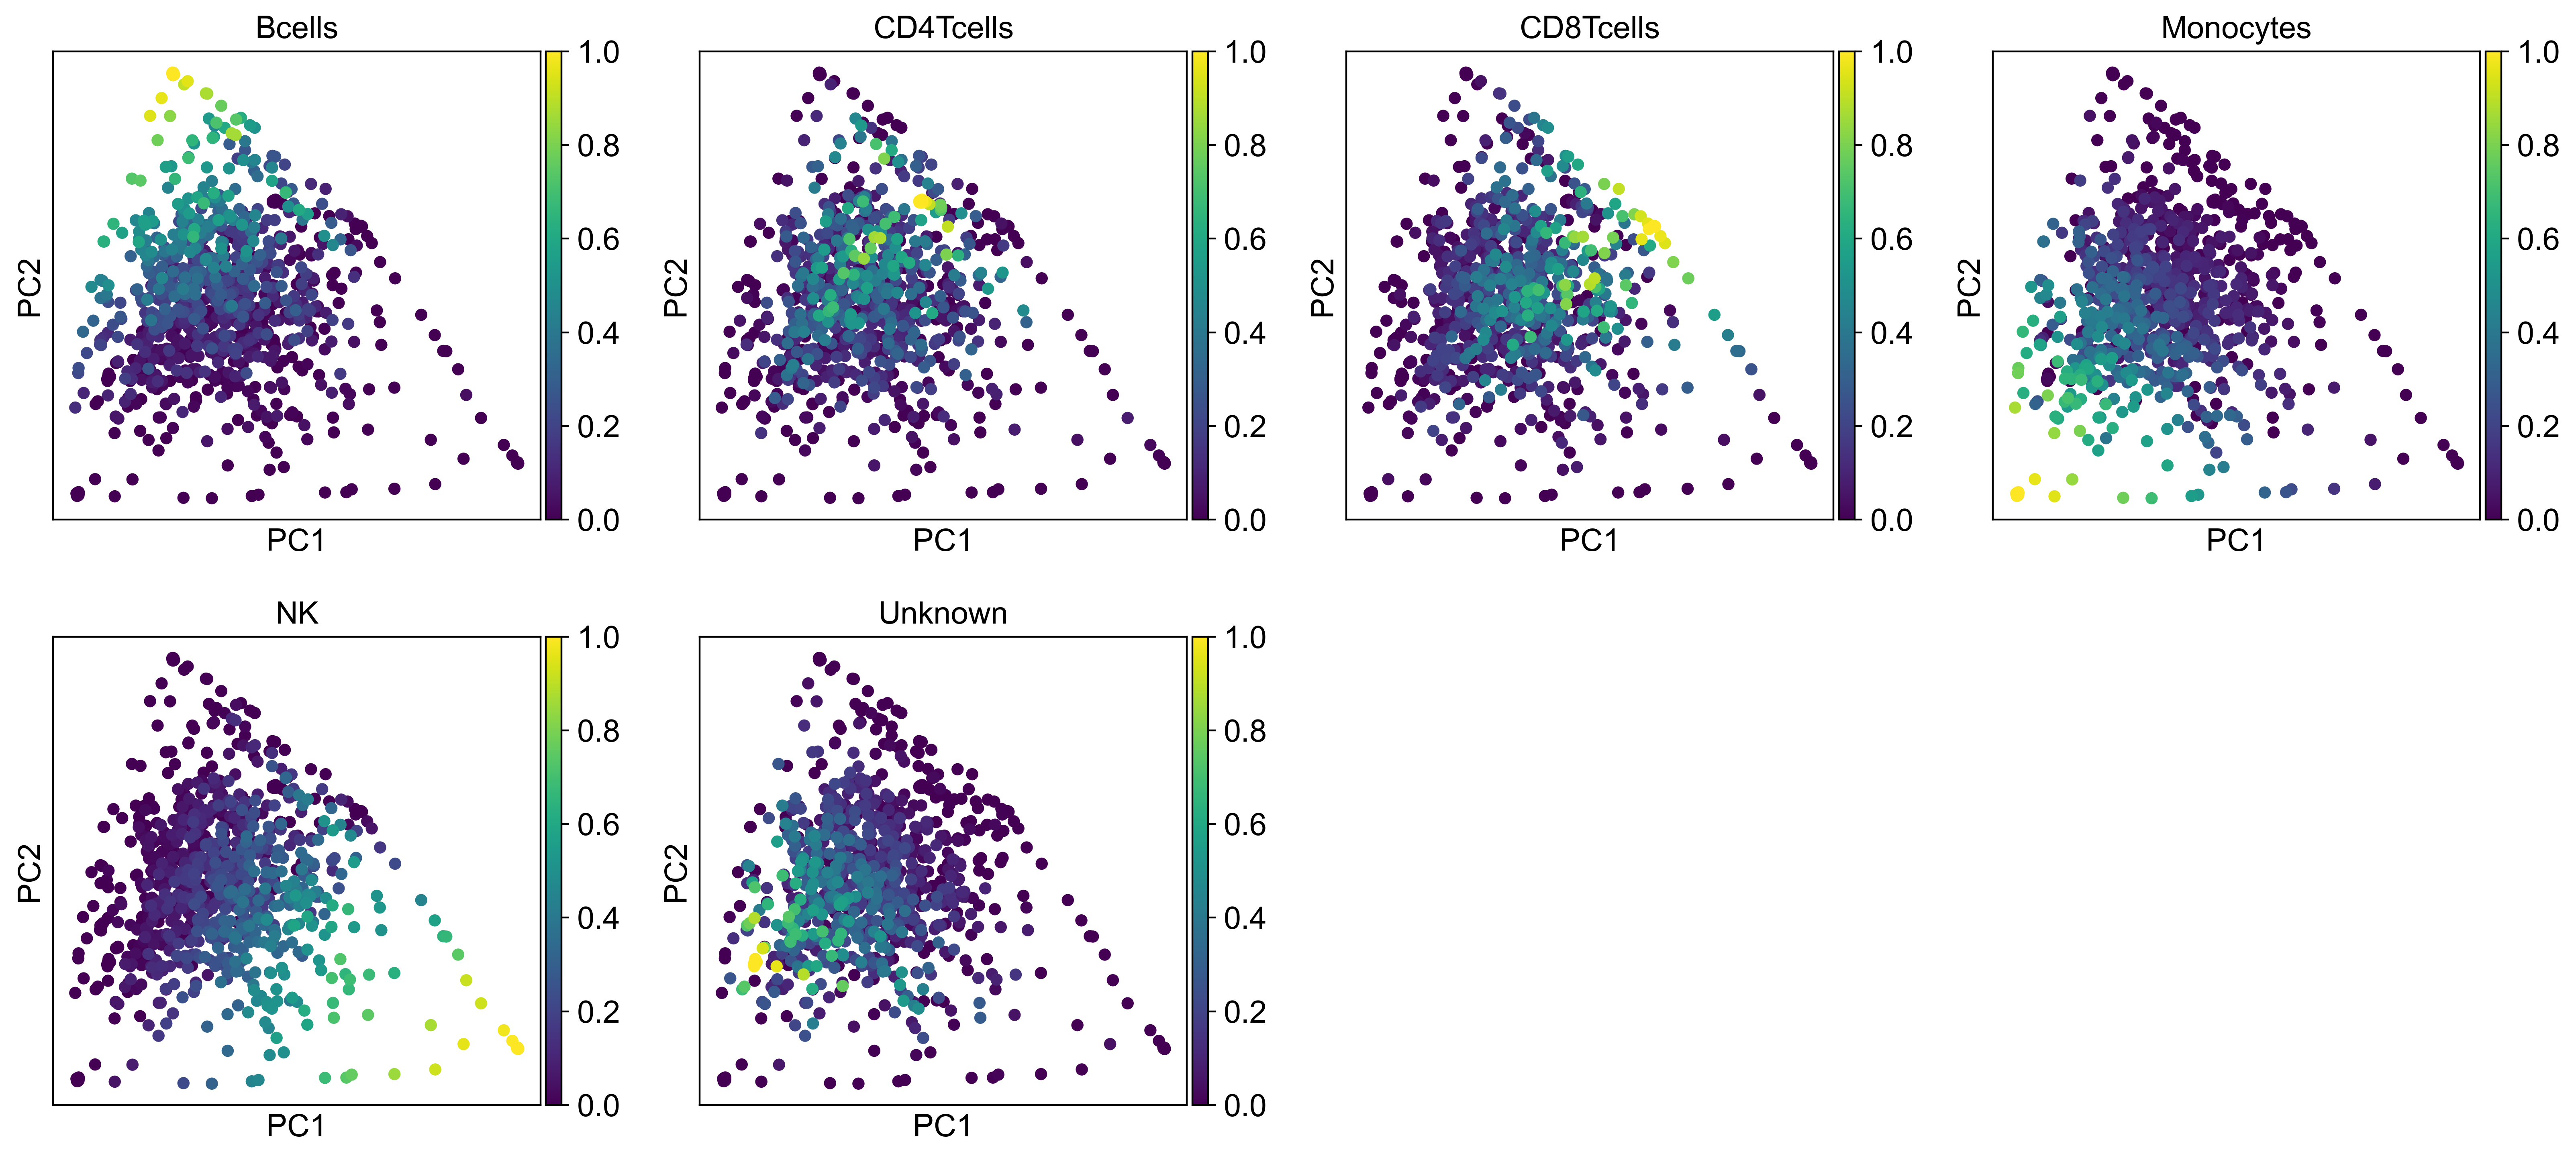

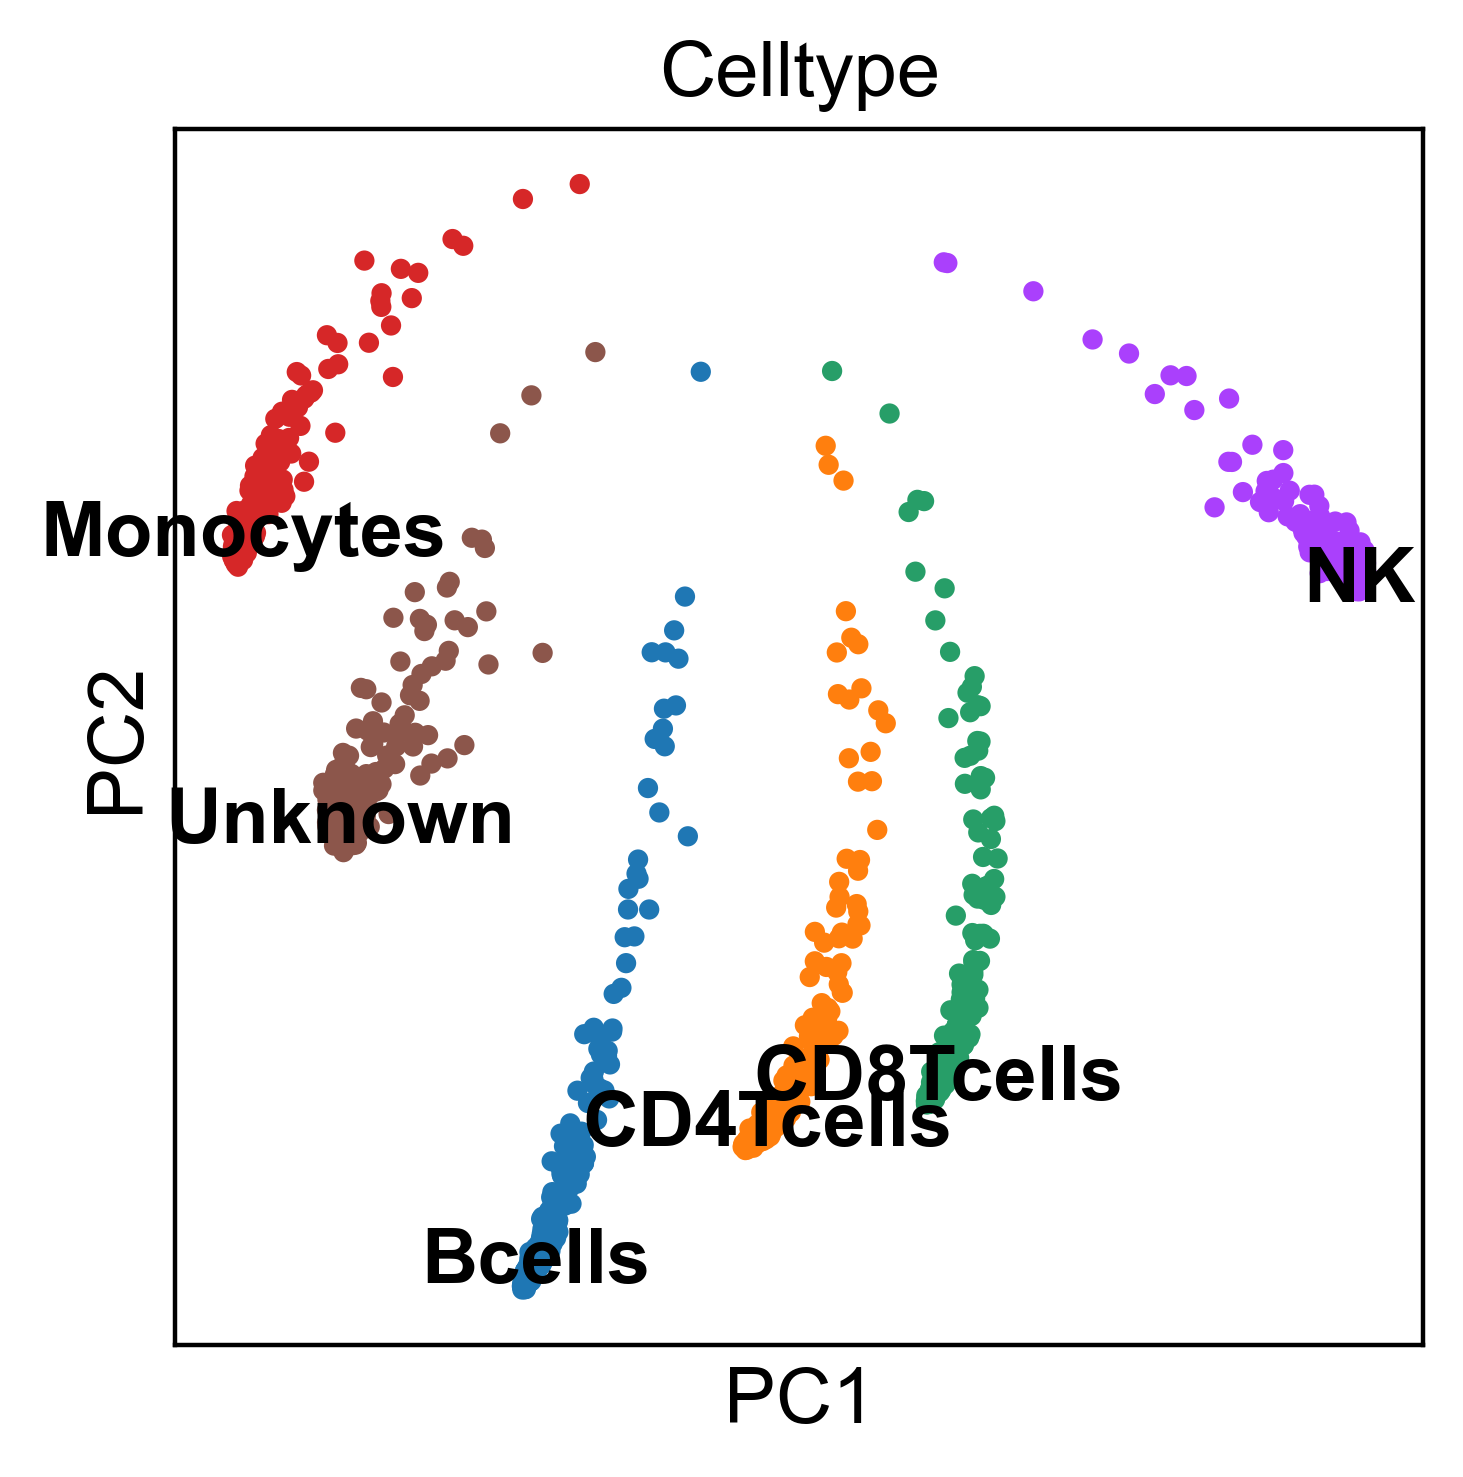

In [10]:
dissect.simulate(config)

# Estimation of fractions

To do this with default parameters, we just need to specify path to bulkRNAseq dataset and its data type

In [11]:
config["deconv_params"]["test_dataset"] = "data/bulkRNAseq/bulk_gse120502.txt"
config["deconv_params"]["test_dataset_format"] = "txt"

In [13]:
# preprocess data
# It does CPM normalization and filters out gene with low variance (cutoff 0.1)

dissect.dataset(config)

Removing genes which have less than 0.1 variance in their expressions.
test dataset has 16872 distinct and variable genes.
simulated dataset has 13669 distinct genes.
There are 11505 common genes between simulated and test dataset.
Saving numpy files.
Done.


In [14]:
# Estimate fractions
dissect.run_dissect_frac(config)

Loading prepared datasets...
Starting training model 0


step: 2| loss: 0.7169:   0%|                   | 1/5000 [00:00<18:42,  4.45it/s]

Network architecture -
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (64, 512)                 5891072   
                                                                 
 dense_1 (Dense)             (64, 256)                 131328    
                                                                 
 dense_2 (Dense)             (64, 128)                 32896     
                                                                 
 dense_3 (Dense)             (64, 64)                  8256      
                                                                 
 dense_4 (Dense)             (64, 6)                   390       
                                                                 
Total params: 6,063,942
Trainable params: 6,063,942
Non-trainable params: 0
_________________________________________________________________
None


step: 5000| loss: 0.0289: 100%|█████████████| 5000/5000 [03:06<00:00, 26.86it/s]


2024-01-12 13:16:12.849126: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tutorial_bulkRNAseq/model_0/assets


2024-01-12 13:16:14.075529: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Running deconvolution
Estimated proportions are saved at tutorial_bulkRNAseq/dissect_fractions_0.txt.
Starting training model 1


step: 6| loss: 0.7651:   0%|                   | 5/5000 [00:00<03:32, 23.54it/s]

Network architecture -
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (64, 512)                 5891072   
                                                                 
 dense_6 (Dense)             (64, 256)                 131328    
                                                                 
 dense_7 (Dense)             (64, 128)                 32896     
                                                                 
 dense_8 (Dense)             (64, 64)                  8256      
                                                                 
 dense_9 (Dense)             (64, 6)                   390       
                                                                 
Total params: 6,063,942
Trainable params: 6,063,942
Non-trainable params: 0
_________________________________________________________________
None


step: 5000| loss: 0.0244: 100%|█████████████| 5000/5000 [03:07<00:00, 26.73it/s]

INFO:tensorflow:Assets written to: tutorial_bulkRNAseq/model_1/assets
Running deconvolution
Estimated proportions are saved at tutorial_bulkRNAseq/dissect_fractions_1.txt.
Starting training model 2


  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Network architecture -
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (64, 512)                 5891072   
                                                                 
 dense_11 (Dense)            (64, 256)                 131328    
                                                                 
 dense_12 (Dense)            (64, 128)                 32896     
                                                                 
 dense_13 (Dense)            (64, 64)                  8256      
                                                                 
 dense_14 (Dense)            (64, 6)                   390       
                                                                 
Total params: 6,063,942
Trainable params: 6,063,942
Non-trainable params: 0
_________________________________________________________________
None


step: 5000| loss: 0.0230: 100%|█████████████| 5000/5000 [03:06<00:00, 26.83it/s]

INFO:tensorflow:Assets written to: tutorial_bulkRNAseq/model_2/assets
Running deconvolution
Estimated proportions are saved at tutorial_bulkRNAseq/dissect_fractions_2.txt.
Starting training model 3


  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Network architecture -
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (64, 512)                 5891072   
                                                                 
 dense_16 (Dense)            (64, 256)                 131328    
                                                                 
 dense_17 (Dense)            (64, 128)                 32896     
                                                                 
 dense_18 (Dense)            (64, 64)                  8256      
                                                                 
 dense_19 (Dense)            (64, 6)                   390       
                                                                 
Total params: 6,063,942
Trainable params: 6,063,942
Non-trainable params: 0
_________________________________________________________________
None


step: 5000| loss: 0.0247: 100%|█████████████| 5000/5000 [03:09<00:00, 26.44it/s]

INFO:tensorflow:Assets written to: tutorial_bulkRNAseq/model_3/assets
Running deconvolution
Estimated proportions are saved at tutorial_bulkRNAseq/dissect_fractions_3.txt.
Starting training model 4


step: 1| loss: 0.6099:   0%|                           | 0/5000 [00:00<?, ?it/s]

Network architecture -
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (64, 512)                 5891072   
                                                                 
 dense_21 (Dense)            (64, 256)                 131328    
                                                                 
 dense_22 (Dense)            (64, 128)                 32896     
                                                                 
 dense_23 (Dense)            (64, 64)                  8256      
                                                                 
 dense_24 (Dense)            (64, 6)                   390       
                                                                 
Total params: 6,063,942
Trainable params: 6,063,942
Non-trainable params: 0
_________________________________________________________________
None


step: 5000| loss: 0.0304: 100%|█████████████| 5000/5000 [03:05<00:00, 26.97it/s]

INFO:tensorflow:Assets written to: tutorial_bulkRNAseq/model_4/assets
Running deconvolution
Estimated proportions are saved at tutorial_bulkRNAseq/dissect_fractions_4.txt.


The resulting files for each model is saved as dissect_fractions_[model_number].txt in the experiment folder specified in config["experiment_folder"].

Let's load our results and see how it is structured, how we can visualize it and use it for downstream analysis.

In [20]:
import os
result_path = os.path.join(config["experiment_folder"],
                          "dissect_fractions.txt")

df = pd.read_table(result_path, index_col=0)
df.head()

,Bcells,CD4Tcells,CD8Tcells,Monocytes,NK,Unknown
T63_LPS_FC1_4,0.031786,0.354534,0.256316,0.195270,0.063419,0.098675
T81_LPS_FC1_4,0.099336,0.384364,0.212654,0.146255,0.038014,0.119377
T104_LPS_FC1_4,0.031305,0.560134,0.184197,0.106352,0.041569,0.076444
T4_GARD_BATCH_2,0.075971,0.396599,0.282686,0.092112,0.067737,0.084894
K47_LPS_FC1_4,0.050185,0.362033,0.225069,0.206960,0.048562,0.107190


## Estimation of cell type specific gene expression 

In [18]:
# Estimate cell type specific gene expression
dissect.run_dissect_expr(config)

Estimating expression of 11529 common genes
Preparing training datasets.


100%|███████████████████████████████████████████| 55/55 [02:34<00:00,  2.80s/it]


Estimated gene expression per cell type is saved at tutorial_bulkRNAseq/est_expression_layered.h5ad and is included in the layers attribute of the anndata object.
Estimated gene expression per cell type for all samples is saved at tutorial_bulkRNAseq/est_expression.h5ad, corresponding samples are in sample attribute of the anndata.obs.


It saves dataset in two ways:
    
**(1)** an h5ad file (est_expression_layered.h5ad) containing counts of bulkRNAseq in .X and corresponding gene expression for each cell type in layers.

**(2)** an h5ad file (est_expression.h5ad) containing counts of cell type specific gene expressions in .X and corresponding sample and cell type name in .obs.

Let's load our results and see how it is structured, how we can visualize it and use it for downstream analysis.

In [41]:
adata_est_layered = sc.read("tutorial_bulkRNAseq/est_expression_layered.h5ad")
print(adata_est_layered)

adata_est = sc.read("tutorial_bulkRNAseq/est_expression.h5ad")
print(adata_est)

AnnData object with n_obs × n_vars = 250 × 11529
    layers: 'Bcells', 'CD4Tcells', 'CD8Tcells', 'Monocytes', 'NK', 'Unknown'
AnnData object with n_obs × n_vars = 1500 × 11529
    obs: 'sample', 'cell_type'
    layers: 'scaled_counts'


We can plot genes for each cell type

In [29]:
sc.set_figure_params(dpi=50)

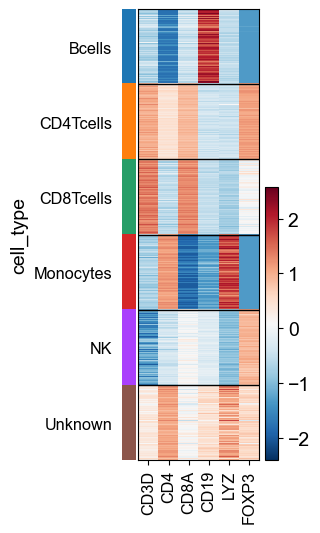

In [43]:
genes = ["CD3D", "CD4", "CD8A", "CD19", "LYZ", "FOXP3"]
sc.pl.heatmap(adata_est, var_names=genes, 
              groupby="cell_type", layer="scaled_counts", cmap="RdBu_r")

In [44]:
sc.pp.highly_variable_genes(adata_est)

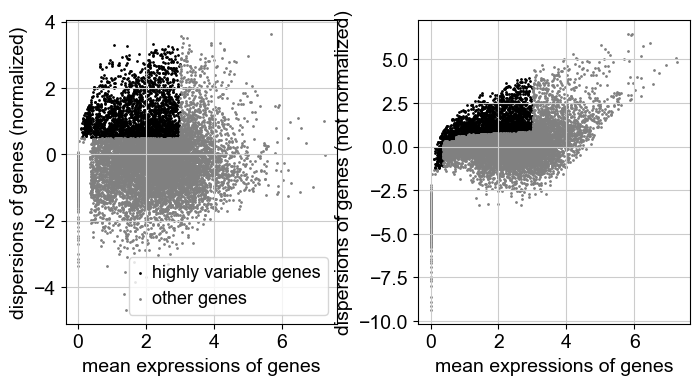

In [45]:
aadatavariable_genes(adata_est)

In [51]:
n_hvg = adata_est.var[adata_est.var.highly_variable].sort_values(by="dispersions",
                                                        ascending=False).index[0:10]

In [58]:
sc.pp.normalize_total(adata_est_layered, target_sum=1e6)
sc.pp.log1p(adata_est_layered)
sc.pp.highly_variable_genes(adata_est_layered)
n_hvg_bulk = adata_est_layered.var[adata_est_layered.var.highly_variable].sort_values(by="dispersions",
                                                        ascending=False).index[0:10]

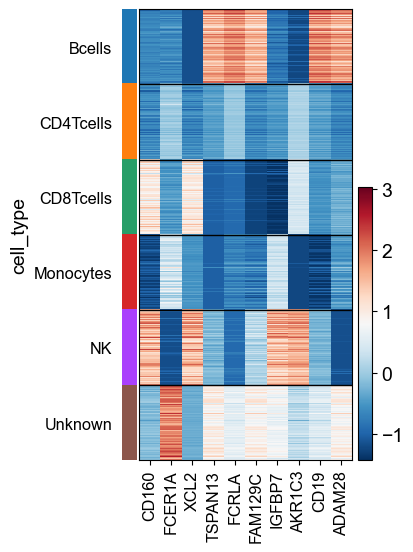

In [52]:
sc.pl.heatmap(adata_est, var_names=n_hvg, 
              groupby="cell_type", layer="scaled_counts", cmap="RdBu_r")

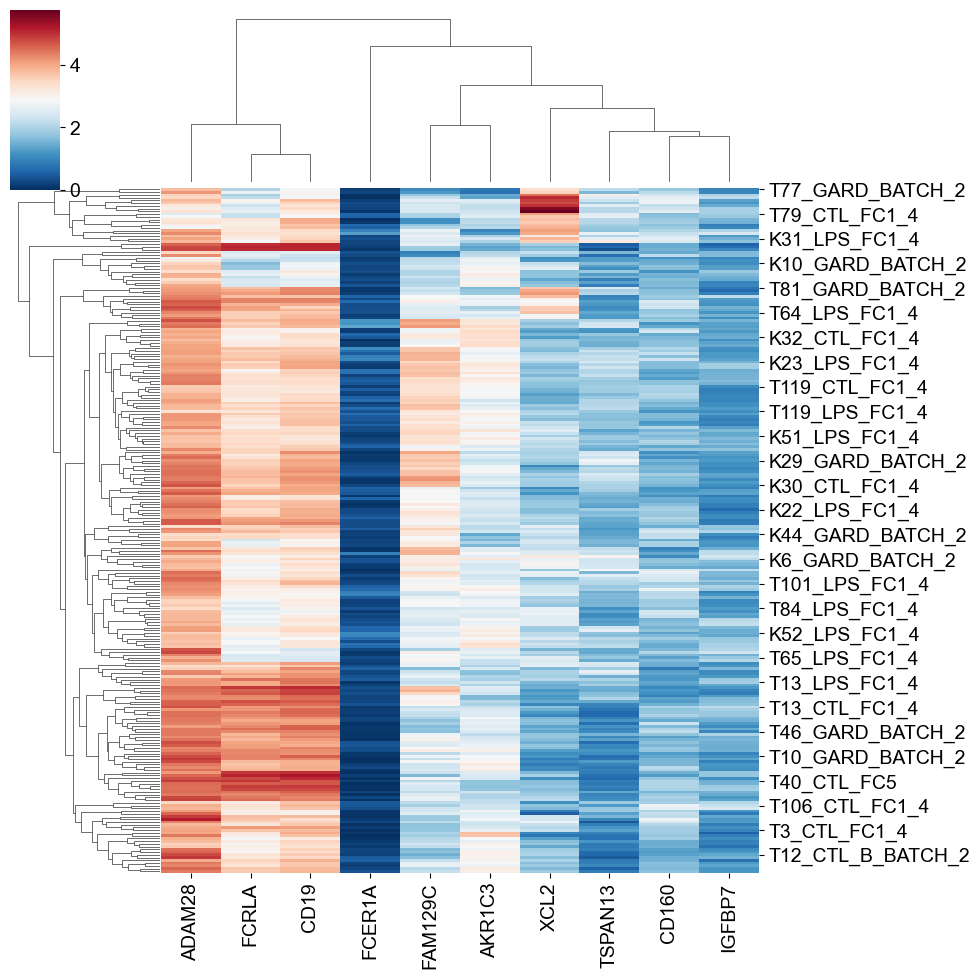

In [64]:
sc.pl.clustermap(adata_est_layered[:, n_hvg], 
              cmap="RdBu_r")

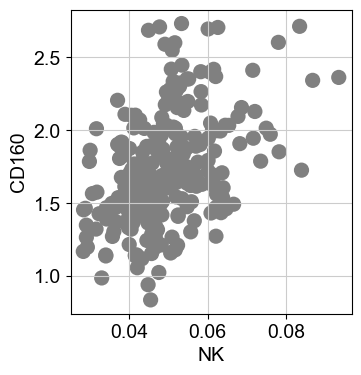

In [78]:
sc.pl.scatter(adata_est_layered, "NK", "CD160",
              )

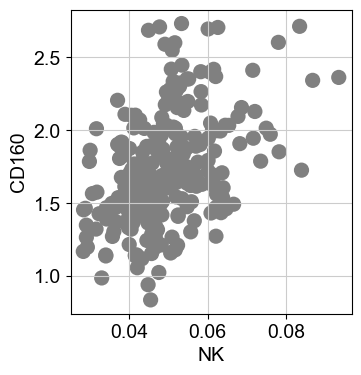

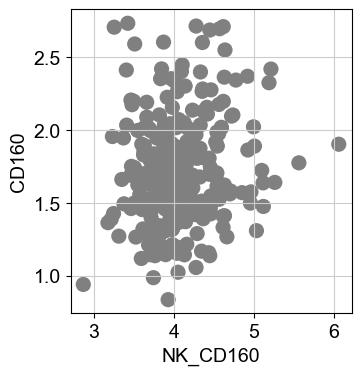

In [79]:
adata_est_layered.obs["NK_CD160"] \
    = adata_est_layered.to_df(layer="NK")["CD160"].tolist()
sc.pl.scatter(adata_est_layered, "NK", "CD160")
sc.pl.scatter(adata_est_layered, "NK_CD160", "CD160")


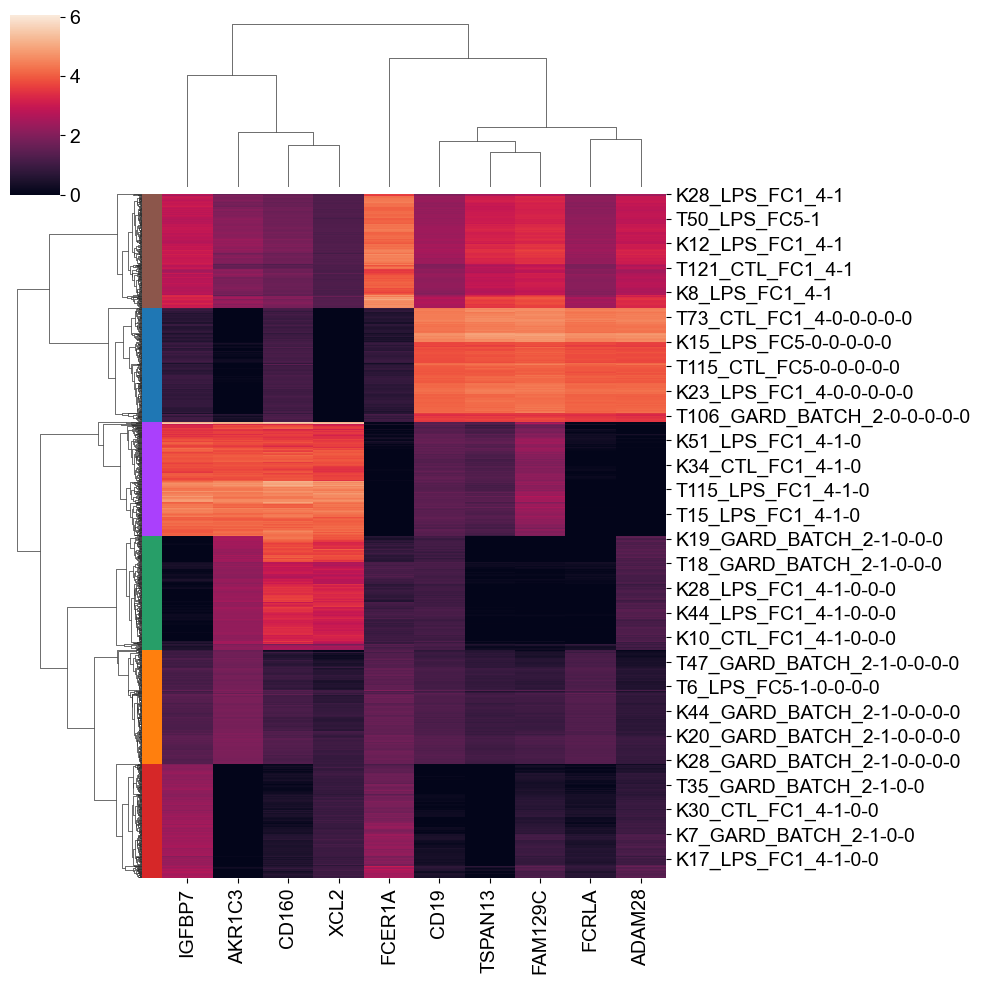

In [56]:
sc.pl.clustermap(adata_est[:,n_hvg], 
                  obs_keys="cell_type")